In [1]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os, time, re, random
# https://stackoverflow.com/a/14463362/12005970
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from numpy import asarray
import pandas as pd
from scipy.sparse import coo_matrix, hstack, load_npz, save_npz
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import pickle

from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn import model_selection
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# import DL libraries
%tensorflow_version 1.x
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv1D, Dense, Activation, LSTM, Reshape, add, dot
from tensorflow.keras.layers import SpatialDropout1D, concatenate, CuDNNGRU,CuDNNLSTM, Bidirectional
from tensorflow.keras.layers import BatchNormalization, Dropout, concatenate, Embedding
from tensorflow.keras.layers import Flatten, MaxPooling1D, AveragePooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, Callback
from tensorflow.keras.utils import plot_model

In [4]:
def load_data():
    """
    this will load the data
    """
    df = pd.read_csv(d+"data.tsv", sep = "\t", header = None, low_memory = True)
    col_names = ["que_no", "question", "answer", "label", "ans_no"]
    print("Before number column in dataset are : ", df.shape[1])
    df.columns = col_names
    # Note: ans_no, que_no column is not useful for this probelm, so I'm droping this column
    df.drop(["que_no","ans_no"], axis = 1, inplace = True)
    print("After droping number columns in dataset are: ", df.shape[1])
    print("Number of datapoints in dataset : {:,}".format(df.shape[0]))
    return df

try:
    stop_words = set(stopwords.words("english"))
except:
    nltk.download('stopwords')
    stop_words = set(stopwords.words("english"))
#removing "not" stop word from stop_words
stop_words = stop_words - {"not", "what", "when", "where", "how", "which"}

##########################################################################################################
#################################### function to pre-process the text ####################################
##########################################################################################################
def text_process(row):
    """
    this function is for pre-processing the text.
    exppand the sentences, remove stopwords, removes html, remove extra space etc.
    """
    try:
        text = row
        text = str(text).lower()
        porter = PorterStemmer()

        #expansion
        text = text.replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
        .replace("n't", " not").replace("what's", "what is").replace("it's", "itis")\
        .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
        .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
        .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar")\
        .replace("€", " euro ").replace("'ll", " will")

        text = re.sub(r"<.*?>","", text) # removes the htmltags: https://stackoverflow.com/a/12982689

        #special character removal
        text = re.sub('[^a-zA-Z0-9\n]', ' ', text)
        #extra space removal
        text = re.sub('\s+',' ', text)

        # stopword removal
        text_to_words = []
        for word in text.split():
            if word not in stop_words:
                text_to_words.append(word)
            else:
                continue
        text = " ".join(text_to_words)

        # stemm the words of sentence
        text = porter.stem(text)

        return text

    except:
        print("There is no value in comment_text, so returnin 'nan'")
        
        return np.nan

##########################################################################################################
#################################### function to design the features  ####################################
##########################################################################################################

def hand_craft_features(data_df):
    """
    this creates the hand crafted features.
    """
    # lenth features
    data_df["que_len"] = data_df["question"].apply(lambda x:len(x))
    data_df["ans_len"] = data_df["answer"].apply(lambda x:len(x))
    data_df["que_word"] = data_df["question"].apply(lambda x:len(x.split()))
    data_df["ans_word"] = data_df["answer"].apply(lambda x:len(x.split()))
    data_df["unique_word_que"] = data_df["question"].apply(lambda x:len(set(x.split())))
    data_df["unique_word_ans"] = data_df["answer"].apply(lambda x:len(set(x.split())))
    #ratio features
    data_df["ratio_q_a_len"] = data_df["que_len"]/data_df["ans_len"]
    data_df["ratio_q_a_word"] = data_df["que_word"]/data_df["ans_word"]
    data_df["ratio_q_a_unique_word"] = data_df["unique_word_que"]/data_df["unique_word_ans"]
    data_df["ration_qword_alen"] = data_df["que_word"]/data_df["ans_len"]
    data_df["ratio_aword_qlen"] = data_df["ans_word"]/data_df["que_len"]
    data_df["ratio_unique_qword_aword"] = data_df["unique_word_que"]/data_df["ans_word"]
    data_df["ratio_unique_aword_qword"] = data_df["unique_word_ans"]/data_df["que_word"]
 
    df.replace([np.inf], np.nan, inplace = True)
    data_df.fillna(0, inplace=True)
    
    return data_df

##########################################################################################################
#################################### function to split the data       ####################################
##########################################################################################################
def split_data(df):
    """
    this will split the data into 80-10-10
    """
    df_train = df.iloc[0:3800000, :] 
    df_cv    = df.iloc[3800000:3900000, :]
    df_test  = df.iloc[3900000:, :]

    X_train, y_train = df_train[[col for col in df.columns if col != "label"]], df_train[["label"]]
    X_cv, y_cv       = df_cv[[col for col in df.columns if col != "label"]], df_cv[["label"]]
    X_test, y_test   = df_test[[col for col in df.columns if col != "label"]], df_test[["label"]]
    return X_train, y_train, X_cv, y_cv, X_test, y_test

##########################################################################################################
#################################### function to plot confudion matrix   #################################
##########################################################################################################
from sklearn.metrics import confusion_matrix
def plot_C_P_R_matrix(y_true, y_pred, name):
    """
    Funtion to plot confusion, precision and recall matrix
    """
    C = confusion_matrix(y_true, y_pred) #for confusion matrix
    # for presion matrix: take the sum column wise, i.e. column normalization
    P = C/C.sum(axis = 0) # it'll have column sum = 1
    #for recall matrix: take the sum row wise, i.e. row normalization
    R = (C.T/C.sum(axis = 1)).T #it'll have row sum = 1

    fig, (ax1, ax2, ax3)  = plt.subplots(1,3, figsize= (19,4))

    #https://seaborn.pydata.org/generated/seaborn.heatmap.html
    sns.heatmap(C, annot = True, fmt = 'd', annot_kws={"size":15}, ax = ax1)
    ax1.set_title("Confusion Matrix", fontsize = 15)
    ax1.set_xlabel("Predicted", fontsize = 12)
    ax1.set_ylabel("Actual", fontsize = 12)

    sns.heatmap(P, annot = True, fmt = '.3f', annot_kws={"size":15}, ax = ax2)
    ax2.set_title("Precision Matrix", fontsize = 15)
    ax2.set_xlabel("Predicted", fontsize = 12)
    ax2.set_ylabel("Actual", fontsize = 12)

    sns.heatmap(R, annot = True, fmt = '.3f', annot_kws={"size":15}, ax = ax3)
    ax3.set_title("Recall Matrix", fontsize = 15)
    ax3.set_xlabel("Predicted", fontsize = 12)
    ax3.set_ylabel("Actual", fontsize = 12)

    plt.show()

########################################################################################
#######################    function to plot Confusion matrix     #######################
########################################################################################
def plot_confusion_matrix(y_train_pred, y_cv_pred, y_test_pred, y_train, y_cv, y_test, thres):
    """
    funtion to plot the precison, recall and confusion matrix for train, cv and test data
    """
    tr_pred = np.where(y_train_pred >= thres, 1, 0)
    cv_pred = np.where(y_cv_pred >= thres, 1, 0)
    te_pred = np.where(y_test_pred >= thres, 1, 0)   

    print(" "*30, "*"*20, "For Train data", "*"*20)
    plot_C_P_R_matrix(y_train.values.flatten(), tr_pred, name = "Train")

    print(" "*30, "*"*20, "For CV data", "*"*20)
    plot_C_P_R_matrix(y_cv.values.flatten(), cv_pred, name = "CV")

    print(" "*30, "*"*20, "For Test data", "*"*20)
    plot_C_P_R_matrix(y_test.values.flatten(), te_pred, name = "Test")

########################################################################################################
############################      function to calculate the MRR        #################################
########################################################################################################
from sklearn.metrics import label_ranking_average_precision_score
def get_mrr(y_true, y_pred):
    """
    to calcuate the mrr.
    it take the y_true and y_pred and make list of lists such that
    for each question ten answer result in list.
    """
    y_true = np.array([y_true[i*10:(i+1)*10] for i in range(len(y_true)//10)])
    y_pred = np.array([y_pred[i*10:(i+1)*10] for i in range(len(y_pred)//10)])
    return label_ranking_average_precision_score(y_true, y_pred)

########################################################################################################
############################     function to report the best model (DL)     ############################
########################################################################################################
def report_model1(model, train_x, cv_x, test_x, y_train, y_cv, y_test, batch_size= 1024, thres = 0.1):
    """
    function take the trained model and report the performance of model on train/cv/test dataset
    """
    y_train_pred = model.predict(train_x, batch_size = batch_size, verbose=1)
    y_cv_pred = model.predict(cv_x, batch_size = batch_size, verbose=1)
    y_test_pred = model.predict(test_x, batch_size = batch_size, verbose=1)

    mrr_score_tr = get_mrr(y_train.values.flatten(), y_train_pred.flatten())
    mrr_score_cv = get_mrr(y_cv.values.flatten(), y_cv_pred.flatten())
    mrr_score_te = get_mrr(y_test.values.flatten(), y_test_pred.flatten())

    print("For this model:\n Train mrr-score: {:.4f}\
    \n CV mrr-score: {:.4f}\n Test mrr-score: {:.4f}".format(mrr_score_tr,
                                                             mrr_score_cv,
                                                             mrr_score_te))
    plot_confusion_matrix(y_train_pred, y_cv_pred, y_test_pred, y_train, y_cv, y_test, thres = thres)
    return mrr_score_tr, mrr_score_cv, mrr_score_te

########################################################################################################
############################     function to convert text into sequence ################################
########################################################################################################
def text_to_seq(texts, keras_tokenizer, max_len):
    """this function  return sequence of text after padding /truncating"""
    x = pad_sequences(keras_tokenizer.texts_to_sequences(texts),maxlen = max_len, padding = 'post',truncating = 'post')
    return x
########################################################################################################
############################     function to convert text into sequence ################################
########################################################################################################
def return_sequnece_embed_matrix(tokens, X_train,X_cv, X_test, max_length_que, max_length_ans):
    """
    this will return the embedded matrix and
    this will also convert question and answer text into sequence
    """
    # creating only one token for both question and answer

    # padding the encoded data to make each datapoint of same dimension
    encoded_que_train = text_to_seq(X_train["question"].values, tokens, max_length_que)
    encoded_que_cv    = text_to_seq(X_cv["question"].values, tokens, max_length_que)
    encoded_que_test  = text_to_seq(X_test["question"].values, tokens, max_length_que)

    print("Shape of train, cv and test {} features are: {}, {}, {}".format('question',
                                                                         encoded_que_train.shape,
                                                                         encoded_que_cv.shape,
                                                                         encoded_que_test.shape))

    # padding the encoded data to make each datapoint of same dimension
    encoded_ans_train = text_to_seq(X_train["answer"].values, tokens, max_length_ans)
    encoded_ans_cv    = text_to_seq(X_cv["answer"].values, tokens, max_length_ans)
    encoded_ans_test  = text_to_seq(X_test["answer"].values, tokens, max_length_ans)

    print("Shape of train, cv and test {} features are: {}, {}, {}".format('answer',
                                                                         encoded_ans_train.shape,
                                                                         encoded_ans_cv.shape,
                                                                         encoded_ans_test.shape))
    
    return encoded_que_train, encoded_que_cv, encoded_que_test, encoded_ans_train, encoded_ans_cv, encoded_ans_test

########################################################################################################
############################     function to get the embedded matrix    ################################
########################################################################################################
def return_embed_matrix(tokens, vocab_size):
    # below array will be used in Embedding layer
    """
    this will give the embedded matrix
    """
    # https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
    file_name = "/content/drive/My Drive/Colab Notebooks/Datasets/Personal Case Study/Glove Vector/glove.6B.200d.txt"
    # gettting the length of unique words in train data,
    # and adding (+1) becasue of zeros padding and words are encoded from 1 to n
    vocab_size = len(tokens.word_index) + 1
    # below array will be used in Embedding layer
    embedding_matrix1 = np.zeros((vocab_size, 200), dtype = 'float32')
    with open(file_name, 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = [float(i) for i in values[1:]]
            word_index = tokens.word_index.get(word) #index of word in our tokenizer
            if word_index:
                embedding_matrix1[word_index] = vector
    return embedding_matrix1

########################################################################################################
############################     defining custom callback               ################################
########################################################################################################
# to create custom callback for prediction: https://stackoverflow.com/a/59231724/12005970
# https://github.com/keras-team/keras/blob/aa21a15bd3b1f5a32f49710d771f2c59deb9c7a0/keras/callbacks.py#L231-L256
class mrr_callback_checkpoint(Callback):
    def __init__(self, filepath, training_data = (), validation_data = (),
                 batch_size = 1024, verbose=0, save_best_only=False):
        super(Callback, self).__init__()
        self.verbose = verbose
        self.filepath = filepath
        self.save_best_only = save_best_only
        self.best = -np.Inf
        self.batch_size = batch_size
        self.x_val, self.y_val = validation_data
        self.x_train, self.y_train = training_data


    def on_epoch_end(self, epoch, logs={}):
        y_pred_train = self.model.predict(self.x_train, batch_size = batch_size)
        y_pred_val = self.model.predict(self.x_val, batch_size = batch_size)
        mrr_train = get_mrr(y_train.values.flatten(), y_pred_train.flatten())
        mrr_cv    = get_mrr(y_cv.values.flatten(), y_pred_val.flatten())
        print('\nEpoch {}: Train MRR: {:.5f} and CV MRR: {:.5f}'.format(epoch+1, mrr_train, mrr_cv))

        if self.save_best_only:
            current = mrr_cv
            if current is None:
                warnings.warn("Can save best model only with {} available, skipping.".format('val mrr-score'), RuntimeWarning)
            else:
                if current > self.best:
                    if self.verbose > 0:
                        print("Epoch %05d: %s improved from %0.5f to %0.5f, saving model to %s"
                              % (epoch+1, 'val mrr-score', self.best, current, self.filepath))
                    self.best = current
                    self.model.save_weights(self.filepath, overwrite=True)
                else:
                    if self.verbose > 0:
                        print("Epoch %05d: %s did not improve" % (epoch+1, 'val mrr-score'))
        else:
            if self.verbose > 0:
                print("Epoch %05d: saving model to %s" % (epoch+1, self.filepath))
            self.model.save_weights(self.filepath, overwrite=True)

########################################################################################################
############################     function to create the model           ################################
########################################################################################################
def create_model(vocab_size, max_length_que, max_length_ans, embedding_matrix1):
    """
    to create the model- QA-LSTM/CNN-attention: https://arxiv.org/pdf/1511.04108.pdf
    """
    K.clear_session()
    def add_bidirection(input_, na):
        x = Bidirectional(CuDNNGRU(32, return_sequences=True), name = "bidirectional_1_"+str(na))(input_)
        avg_pool = AveragePooling1D(pool_size = 2, padding = 'same', name = 'avg_pool_'+str(na))(x)
        return avg_pool
    # question input
    que_input  = Input(shape = (max_length_que, ), name = "que_layer")
    embed_text1 = Embedding(input_dim = vocab_size, output_dim = 200,
                                weights=[embedding_matrix1], input_length = max_length_que,
                                trainable = False, name = 'que_embedding')(que_input)
    # answer input
    ans_input  = Input(shape = (max_length_ans, ), name = "ans_layer")
    embed_text2 = Embedding(input_dim = vocab_size, output_dim = 200,
                                weights=[embedding_matrix1], input_length = max_length_ans,
                                trainable = False, name = 'ans_embedding')(ans_input)

    avg_pool1 = add_bidirection(embed_text1, na = 'q')
    avg_pool2 = add_bidirection(embed_text2, na = 'a')

    # dot product of maxpooling of question with maxpooling of answer
    dot1 = dot([avg_pool1, avg_pool2], axes=-1, name='dot_of_max')
    flat1 = Flatten(name='flatten_1')(dot1)
    out = Dense(1, activation='sigmoid', name = "output_layer")(flat1)

    model = Model(inputs=[que_input, ans_input], outputs = out, name = "Model_2")
    return model

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
d = "/content/drive/My Drive/Colab Notebooks/Datasets/Personal Case Study/Search Engine/"
model_path = d+"Models/"
max_length_que = 50
max_length_ans = 250
n_epochs = 10
batch_size = 1024

## **`train()` function**

In [0]:
def train():
    if not os.path.isfile(d+"Processed Data/text_processed.csv"):
        print("processed data is not in drive, let's create...")
        #laod the data
        df = load_data()
        # pre-process text data
        df.loc[:,"question"] = df["question"].apply(text_process)
        df.loc[:,"answer"] = df["answer"].apply(text_process)
        # relacing such question and answers with np.Nan and then droping them
        df.replace(["", "null"], np.nan, inplace = True)
        df.dropna(axis = 0, how = "any", inplace= True)
        # drop duplicates
        df.drop_duplicates(subset = ["question", "answer"], keep = False, inplace = True)

        # Let's remove the questions that have more than 1 correct answer
        # https://stackoverflow.com/a/43501282/12005970
        a = df.groupby('question')\
                .agg({'answer': 'count', 'label': 'sum'})\
                .reset_index()\
                .rename(columns={'answer':'total answers', 'label': 'correct answers'})
        # questions that have more than 1 correct answer
        multiple_correct_answers_df = a[(a['correct answers']>1) 
                                        or (a['correct answers'] == 0)
                                        or (a['total answers'] < 10)
                                        or (a['total answers'] > 10)]
        df.drop(df[df['question'].isin(multiple_correct_answers)].index, axis = 0, inplace=True)
        df.reset_index(inplace=True, drop= True)

        # design text based features
        df = hand_craft_features(df)
        df = df.head(4000000)
    else:
        print("laoding the processed dataset from drive...")
        df = pd.read_csv(d+"Processed Data/text_processed.csv", low_memory=True)
        df = df.head(4000000)
    
    # split the dataset
    print("splitting the data...")
    X_train, y_train, X_cv, y_cv, X_test, y_test = split_data(df)
    
    print("creating tokens...")
    if not os.path.isfile(d+"Models/tokens.pkl"):
        print("tokenizer is not in the disk, so creating it...")
        tokens = Tokenizer()
        tokens.fit_on_texts(list(df["question"]+ " "+ df["answer"]))
        with open(d+"Models/tokens.pkl", "wb") as f:
            pickle.dump(tokens, f)
    else:
        print("tokenizer is in the disk, so laoding from the disk...")
        with open(d+"Models/tokens.pkl", "rb") as f:
            tokens = pickle.load(f)

    vocab_size = len(tokens.word_index) + 1    

    print("converting text into sequence...")
    encoded_que_train, encoded_que_cv, encoded_que_test,\
    encoded_ans_train, encoded_ans_cv, encoded_ans_test = return_sequnece_embed_matrix(tokens, X_train,X_cv, X_test,
                                                                                       max_length_que, max_length_ans)
    embedding_matrix1 = return_embed_matrix(tokens, vocab_size)

    print("creating the model...")
    model = create_model(vocab_size, max_length_que, max_length_ans, embedding_matrix1)
    print(model.summary())
    if not os.path.isfile(d+"Models/Model_2.h5"):
        print("trained model is not in disk, let's train it...")
        es = EarlyStopping(monitor = 'val_loss', mode = 'min', min_delta = 0.001, patience = 5, verbose = 1)
        pe = mrr_callback_checkpoint(filepath = d+"Models/Model_2.h5",
                                    training_data = ([encoded_que_train,
                                                      encoded_ans_train], y_train),
                                    validation_data = ([encoded_que_cv,
                                                        encoded_ans_cv], y_cv),
                                    verbose = 1, save_best_only = True)


        model.compile(loss='binary_crossentropy', optimizer = "rmsprop")
        model.fit([encoded_que_train, encoded_ans_train], y_train,
                  validation_data = ([encoded_que_cv, encoded_ans_cv], y_cv),
                  epochs = n_epochs, batch_size = batch_size, callbacks = [es, pe])
    else:
        print("trained model is in the disk. Loading the model from disk...")
        model.load_weights(d+"Models/Model_2.h5")
        tr, cv, te = report_model1(model,
                                [encoded_que_train, encoded_ans_train],
                                [encoded_que_cv, encoded_ans_cv],
                                [encoded_que_test, encoded_ans_test],
                                y_train, y_cv, y_test, batch_size = 1024)
    return model, tr, cv, te

laoding the processed dataset from drive...
splitting the data...
creating tokens...
tokenizer is in the disk, so laoding from the disk...
converting text into sequence...
Shape of train, cv and test question features are: (3800000, 50), (100000, 50), (100000, 50)
Shape of train, cv and test answer features are: (3800000, 250), (100000, 250), (100000, 250)
creating the model...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "Model_2"
_________________________________________________

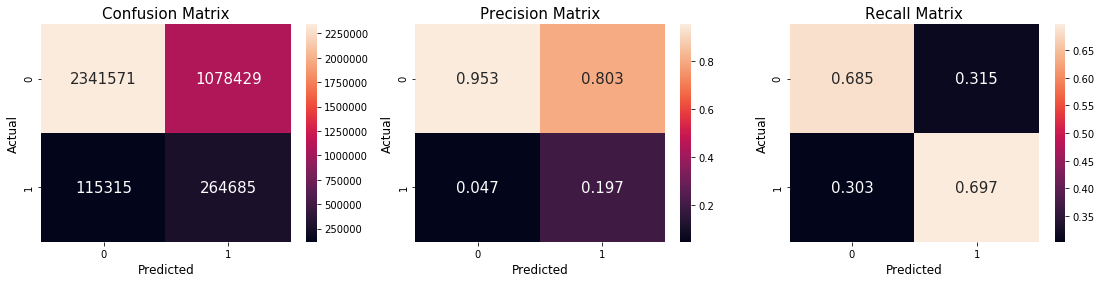

                               ******************** For CV data ********************


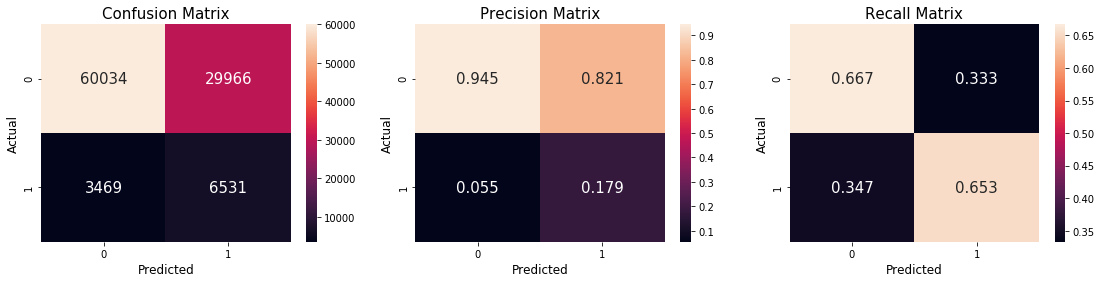

                               ******************** For Test data ********************


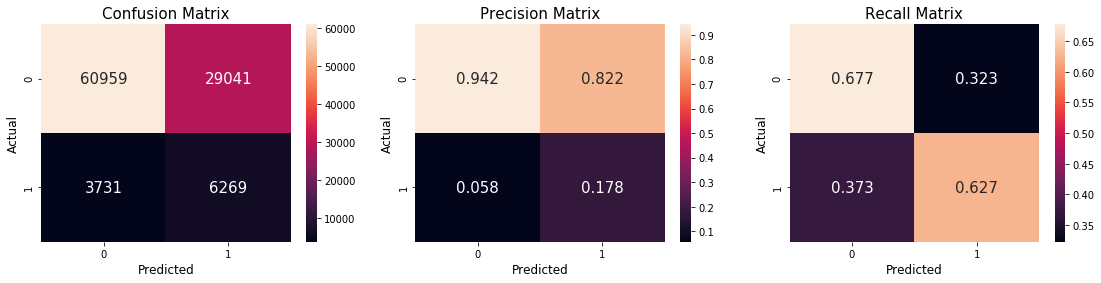

In [7]:
best_model, tr, cv, te = train()

## **`final1()` fnction**

* This function will take the data in (X,Y) format give the performance of model.
* It is like evaluating function for the model.

**Note:** Before sending (X,Y) in function make sure that they follow these conditions-
* Each question must have only 10 answer and only one of them should be correct.
* First 10 row will correspond first question, next 10 rows will correspond to next question, next 10 rows will correspond to third question and so on. 

In [8]:
# trained model and saved tokener will be same for both functions
# let's load them first

#loading tokenizer
print("tokenizer is in the disk, so laoding from the disk...")
with open(d+"Models/tokens.pkl", "rb") as f:
    tokens = pickle.load(f)

vocab_size = len(tokens.word_index) + 1
embedding_matrix1 = return_embed_matrix(tokens, vocab_size)

print("creating the model...")
model = create_model(vocab_size, max_length_que, max_length_ans, embedding_matrix1)
print('loading weights...')
model.load_weights(d+"Models/Model_2.h5")

tokenizer is in the disk, so laoding from the disk...
creating the model...
loading weights...


In [0]:
# loading the dataset. it satisfies above two condition
df = pd.read_csv(d+"Processed Data/text_processed.csv", low_memory=True)
df = df.head(4000000)
X = df[['question','answer']]
Y = df['label']

In [0]:
def final1(X,Y):
    '''
    this function will take (X,Y) and returns the MRR.
    this alos print the confusion, precision and recall matrix.
    X: dataframe: it has two columns [['question','answer']]
    Y: it can dataframe, or panadas series. it has the class labels

    X and Y must satisfy this two condition, other actual result be differe
    1. each question must have only 10 answers and only of them should be correct.
    2. First 10 row will correspond first question, next 10 rows will correspond to next question,
     next 10 rows will correspond to third question and so on.
    '''
    #connvert text into sequence
    print('text to sequnce...')
    que_seq = text_to_seq(X['question'], tokens, max_length_que)
    ans_seq = text_to_seq(X['answer'], tokens, max_length_ans)

    # prediction
    Y_pred = model.predict([que_seq, ans_seq], batch_size=1024, verbose=1)

    # calculating the MRR
    mrr = get_mrr(Y.values.flatten(), Y_pred.flatten())
    return mrr

In [11]:
mrr = final1(X,Y)
print('MRR = {:.4f}'.format(mrr))

text to sequnce...
4000000/4000000 [==============================] - 148s 37us/sample
MRR = 0.5436


**NOTE:** This **MRR** is high because I used whole data that I've used for training, validation and testing. This `X` includes the training data, that's why we got higher vlaue of **MRR**

## **`final2()` function**

* This function will take the `X` only predict whether the question is correct or not.

In [0]:
def final2(X):
    '''
    this function take `X` and return predicted Y {0,1}
    X: is dataframe: [['question','answer']]
    function will predict the label of question and answer pair.
    predicted values real values between 0 and 1 (sigmoid output).
    threshold = 0.1 for classifying as 1 or 0
    np.where(pred>=0.1,1,0) 
    '''
    #connvert text into sequence
    print('text to sequnce...')
    que_seq = text_to_seq(X['question'], tokens, max_length_que)
    ans_seq = text_to_seq(X['answer'], tokens, max_length_ans)

    pred = model.predict([que_seq, ans_seq], batch_size = 1024, verbose=1)
    return np.where(pred>0.1,1,0)

In [13]:
Y_pred = final2(X)

text to sequnce...
4000000/4000000 [==============================] - 143s 36us/sample


In [14]:
from sklearn.metrics import classification_report
print(classification_report(Y.values.flatten(), Y_pred.flatten()))

              precision    recall  f1-score   support

           0       0.95      0.68      0.80   3600000
           1       0.20      0.69      0.31    400000

    accuracy                           0.69   4000000
   macro avg       0.57      0.69      0.55   4000000
weighted avg       0.88      0.69      0.75   4000000

